In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import osmnx as ox
from functools import partial
import numpy as np
import pandas as pd
from multiprocessing import Pool,cpu_count
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import MultiLineString,MultiPoint,Point,LineString,MultiPolygon
from shapely import wkt
from shapely.ops import nearest_points
import glob
import time
import gpxpy
from itertools import groupby
import random
import sklearn
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
from lib_garmin_elevation import *


In [2]:
def get_longest_path(GG,GG_un):
    edges=sorted(list(GG.edges(keys=True,data=True)),key=lambda x:len(set(x[3]['file_paths'])))
    path=[edges[-1][:3]]
    stop_previous=stop_next=False
    while len(path)==len(set(path)) and not(stop_previous) and not(stop_next):
        first_edge,last_edge=path[0],path[-1]
        next_edges=[elem for elem in GG_un.edges(last_edge[1],keys=True) if elem[1]!=last_edge[0]]
        if len(next_edges)==0:
            stop_next=True
        else:
            next_edges=sorted(next_edges,key=lambda x:get_edge_score(GG,last_edge,x))
            next_edge=next_edges[-1]
            next_score=get_edge_score(GG,last_edge,next_edge)
            if next_score==0.:
                stop_next=True
            else:
                path=path+[next_edge]
        previous_edges=[(elem[1],elem[0],elem[2]) for elem in GG_un.edges(first_edge[0],keys=True) if elem[1]!=first_edge[1]]
        if len(previous_edges)==0:
            stop_previous=True
        else:
            previous_edges=sorted(previous_edges,key=lambda x:get_edge_score(GG,x,first_edge))
            previous_edge=previous_edges[-1]
            previous_score=get_edge_score(GG,previous_edge,first_edge)
            if previous_score==0.:
                stop_previous=True
            else:
                path=[previous_edge]+path        
    return path

def pre_edge_score(GG,edge_1,edge_2):
    if not(edge_1 in GG.edges(keys=True) and edge_2 in GG.edges(keys=True)):
        return 0.
    datum_1,datum_2=GG.get_edge_data(*edge_1),GG.get_edge_data(*edge_2)
    return len(set(datum_1['file_paths']).intersection(set(datum_2['file_paths'])))
    L1=zip(datum_1['file_paths'],datum_1['id_segment'])
    L2=zip(datum_2['file_path'],datum_2['id_segment'])
    return len([_ for (file_path_1,id_segment_1),(file_path_2,id_segment_2) in product(L1,L2) if file_path_1==file_path_2 and id_segment_2==id_segment_1+1])

def get_edge_score(GG,edge_1,edge_2):
    return max(pre_edge_score(GG,edge_1,edge_2),pre_edge_score(GG,(edge_2[1],edge_2[0],edge_2[2]),(edge_1[1],edge_1[0],edge_1[2])))
    

0.057366132736206055


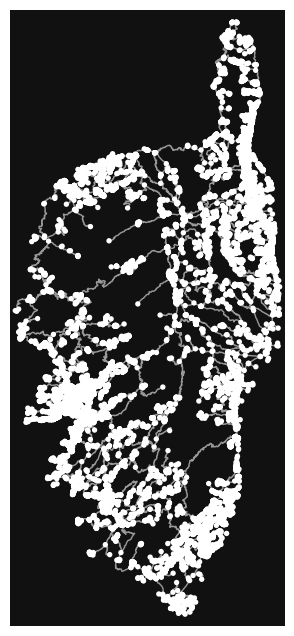

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
place_name='Corse, France'
G_dir=ox.graph_from_place(place_name,network_type='drive')
crs=ox.graph_to_gdfs(G_dir,edges=False).estimate_utm_crs()
G_proj=ox.project_graph(G_dir,to_crs=crs)
G_proj=nx.MultiGraph(G_proj)
t1=time.time()
add_missing_geometries(G_proj)
t2=time.time()
print(t2-t1)

ox.plot_graph(G_proj)


In [4]:
def parallelized_preprocess(file_paths):
    garmin_dfs=[preprocess(file_path,G_proj,crs=crs) for file_path in file_paths]
    return pd.concat(garmin_dfs)

In [5]:
GENERATE=True
garmin_df_path='/home/pierre/Documents/garmin_df.csv'
if GENERATE:
    t1=time.time()
    nb_cpu=cpu_count()-1
    file_paths=glob.glob('/home/pierre/Documents/garmin_corse/*.gpx')
    chunked_file_paths=chunk(file_paths,nb_cpu)
    with Pool(nb_cpu) as p:
        garmin_dfs=p.map(parallelized_preprocess,chunked_file_paths)
    garmin_df=pd.concat(garmin_dfs)
    garmin_df=garmin_df.to_crs('epsg:4326')
    garmin_df.to_csv(garmin_df_path,index=False)
    garmin_df=garmin_df.to_crs(crs)
    t2=time.time()
    print(t2-t1)
else:
    garmin_df=pd.read_csv(garmin_df_path)
    garmin_df['geometry']=garmin_df['geometry'].apply(wkt.loads)
    garmin_df=gpd.GeoDataFrame(garmin_df,geometry='geometry',crs='epsg:4326')
    garmin_df['time']=pd.to_datetime(garmin_df['time'])
    garmin_df['edge']=garmin_df['edge'].apply(eval)
    garmin_df=garmin_df.to_crs(crs)
garmin_df

reading file took 0.828495 s
estimating crs took 0.056793 s
reading file took 1.160224 s
estimating crs took 0.023970 s
reading file took 1.352570 s
estimating crs took 0.025976 s
reading file took 1.463376 s
estimating crs took 0.033715 s
reading file took 2.224494 s
estimating crs took 0.030934 s
reading file took 2.634892 s
reading file took 2.896791 s
estimating crs took 0.282963 s
estimating crs took 0.044126 s
projecting took  1.824620 s
projecting took  1.666791 s
projecting took  2.446481 s
projecting took  1.874201 s
adding segments took 0.706460 s
reading file took 0.097304 s
adding segments took 0.499955 sadding segments took 0.539371 s
estimating crs took 0.011534 s

adding segments took 1.248484 s
reading file took 0.570834 s
estimating crs took 0.024637 s
projecting took  0.755425 s
reading file took 0.913229 s
estimating crs took 0.015746 s
adding segments took 0.468388 s
reading file took 0.734454 s
estimating crs took 0.016688 s
projecting took  1.556942 s
projecting t

file_path  \
0      /home/pierre/Documents/garmin_corse/activity_1...   
1      /home/pierre/Documents/garmin_corse/activity_1...   
2      /home/pierre/Documents/garmin_corse/activity_1...   
3      /home/pierre/Documents/garmin_corse/activity_1...   
4      /home/pierre/Documents/garmin_corse/activity_1...   
...                                                  ...   
14390    /home/pierre/Documents/garmin_corse/albin_2.gpx   
14391    /home/pierre/Documents/garmin_corse/albin_2.gpx   
14392    /home/pierre/Documents/garmin_corse/albin_2.gpx   
14393    /home/pierre/Documents/garmin_corse/albin_2.gpx   
14394    /home/pierre/Documents/garmin_corse/albin_2.gpx   

                             geometry  elevation                      time  \
0      POINT (482452.154 4710449.517)   8.200000 2023-09-05 13:57:31+00:00   
1      POINT (482455.064 4710445.288)  30.200001 2023-09-05 13:57:32+00:00   
2      POINT (482458.498 4710440.297)  32.400002 2023-09-05 13:57:33+00:00   
3      POINT (482461.864 4710435.404)  33.000000 2023-09-05 13:57:34+00:00   
4      POINT (482464.925 4710430.956)  33.400002 2023-09-05 13:57:35+00:00   
...                               ...        ...                       ...   
14390  POINT (482316.873 4710646.124)  69.000000 2021-04-01 14:31:32+00:00   
14391  POINT (482314.310 4710649.848)  69.000000 2021-04-01 14:31:33+00:00   
14392  POINT (482312.549 4710652.407)  69.000000 2021-04-01 14:31:34+00:00   
14393  POINT (482311.203 4710654.365)  70.000000 2021-04-01 14:31:35+00:00   
14394  POINT (482310.766 4710655.000)  70.000000 2021-04-01 14:31:36+00:00   

                            edge  distance_ls pre_segment orientation segment  \
0      (51319395, 9064150112, 0)   406.639341           0         1.0       0   
1      (51319395, 9064150112, 0)   411.773043           0         1.0       0   
2      (51319395, 9064150112, 0)   417.831396           0         1.0       0   
3      (51319395, 9064150112, 0)   423.769641           0         1.0       0   
4      (51319395, 9064150112, 0)   429.169124           0         1.0       0   
...                          ...          ...         ...         ...     ...   
14390  (51319395, 9064150112, 0)   167.986536          44        -1.0      83   
14391  (51319395, 9064150112, 0)   163.465646          44        -1.0      83   
14392  (51319395, 9064150112, 0)   160.359109          44        -1.0      83   
14393  (51319395, 9064150112, 0)   157.983103          44        -1.0      83   
14394  (51319395, 9064150112, 0)   157.212514          44        -1.0      83   

      merge_segment  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
14390            52  
14391            52  
14392            52  
14393            52  
14394            52  

[310271 rows x 10 columns]

6.63013219833374


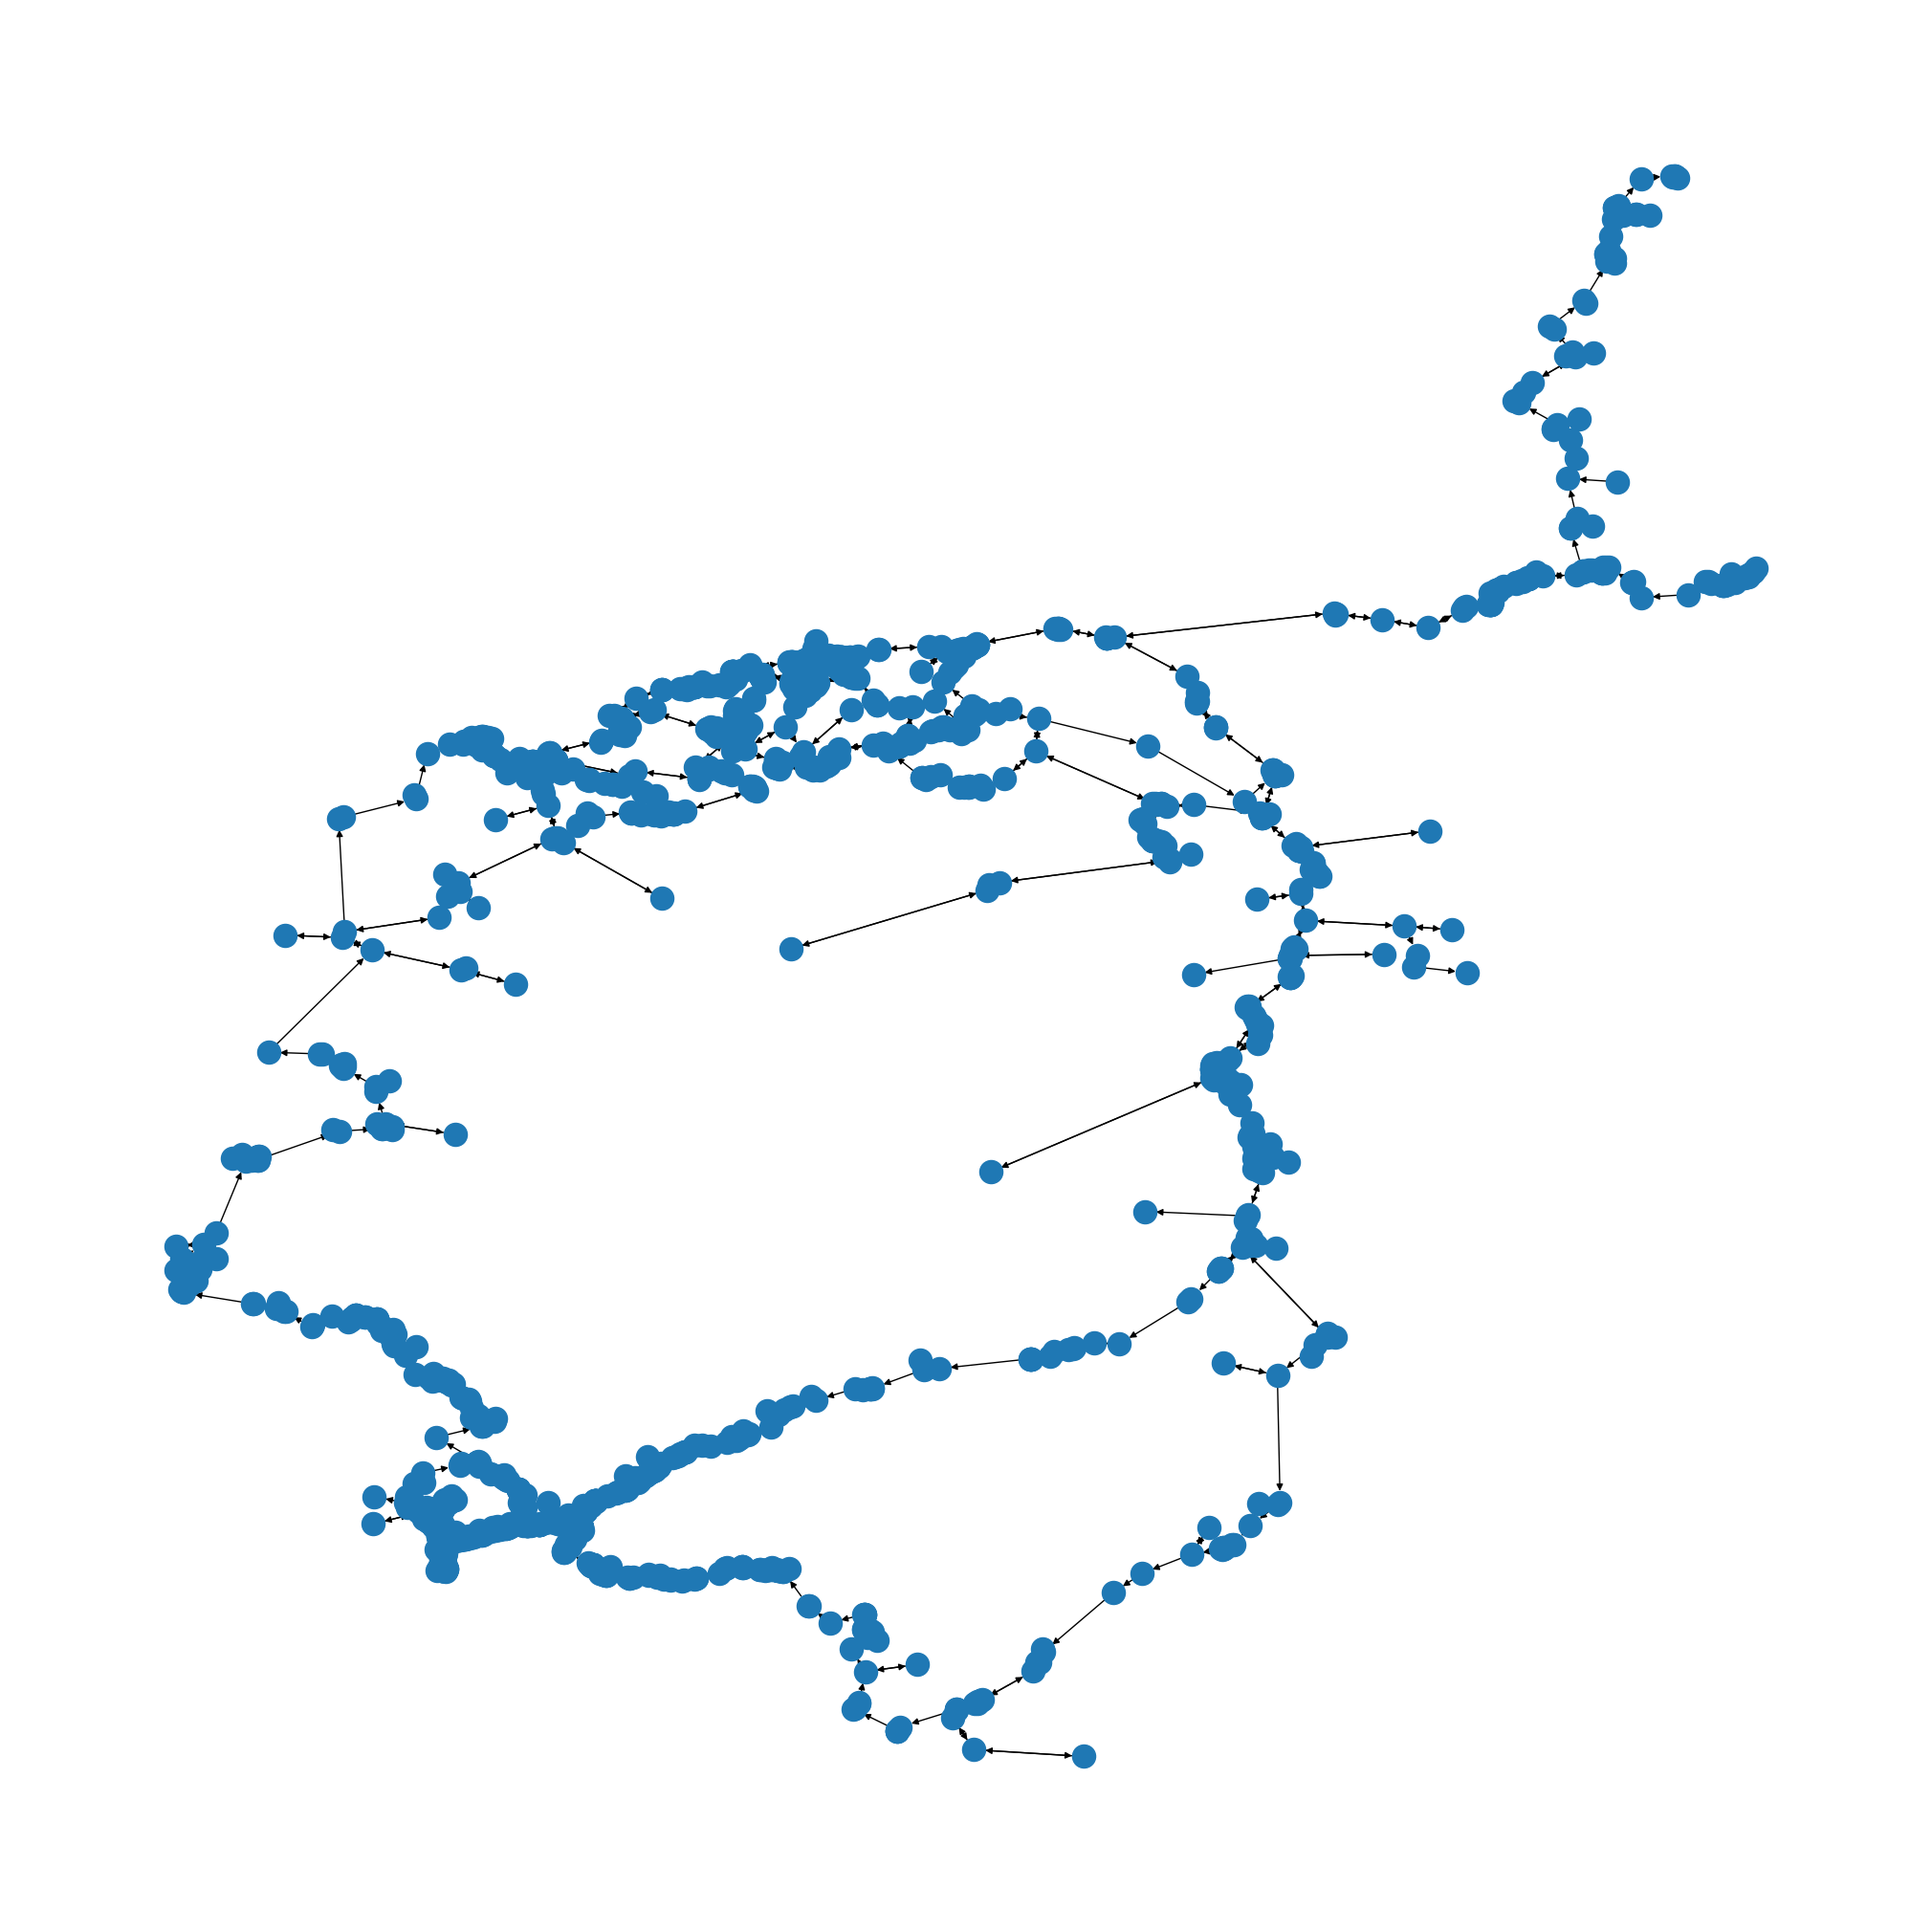

In [39]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
GG=build_multidigraph(G_proj,garmin_df)
GG_un=nx.Graph(GG)
t2=time.time()
print(t2-t1)
pos={node:(data['x'],data['y']) for node,data in GG.nodes(data=True)} 
nx.draw(GG,pos=pos)

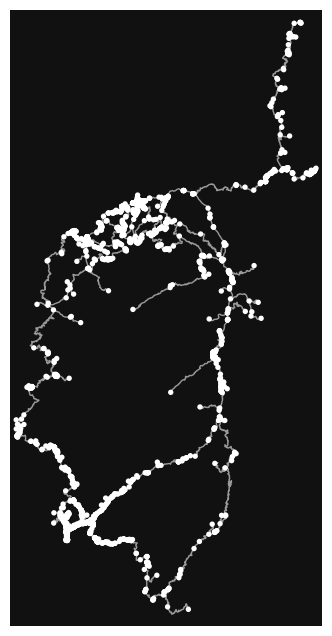

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
edges=list(GG.edges(keys=True))
ox.plot_graph(nx.edge_subgraph(G_proj,edges))

In [19]:
nx.set_edge_attributes(GG,{edge[:3]:{'weight':-len(set(edge[3]['file_paths']))} for edge in GG.edges(keys=True,data=True)})

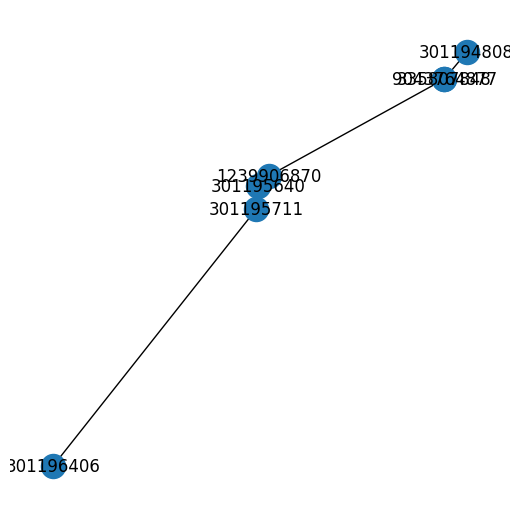

In [94]:
plt.rcParams['figure.figsize']=(5,5)
ref_edges=[edge[:3] for edge in GG.edges(data=True,keys=True) if 'ref' in edge[3] and edge[3] ['ref']=='D 147']
ref_G=GG.edge_subgraph(ref_edges)
ref_G=nx.MultiGraph(ref_G)
pos={node:(data['x'],data['y']) for node,data in G_proj.nodes(data=True)} 
nx.draw(ref_G,pos=pos,with_labels=True)

In [95]:
def custom_shortest_path(G,node_1,node_2):
    path=nx.shortest_path(G,node_1,node_2,weight='length')
    edges=[path[i:i+2] for i in range(len(path)-1)]
    for k,edge in enumerate(edges):
        data=G.get_edge_data(*edge)
        edge_keys=data.keys()
        edge_key=sorted(edge_keys,key=lambda edge_key:len(G.get_edge_data(edge[0],edge[1],edge_key)['Xs']))[-1]
        edges[k]=edge+[edge_key]
    return edges
        

In [96]:
paths=[]
ref_G_simple=nx.Graph(ref_G)
for cc in nx.connected_components(ref_G_simple):
    extremities=[node for node in cc if ref_G_simple.degree(node)==1]
    if len(extremities)>1:
        shortest_paths=[custom_shortest_path(ref_G,node_1,node_2) for node_1,node_2 in combinations(extremities,2)]
        #shortest_paths=[nx.shortest_path(ref_G,node_1,node_2) for node_1,node_2 in combinations(extremities,2)]

        shortest_paths=sorted(shortest_paths,key=len)
        paths.append(shortest_paths[-1])
paths=sorted(paths,key=len)
len(paths)

1

In [97]:
path=paths[-1]
len(path)


6

0.0016109943389892578


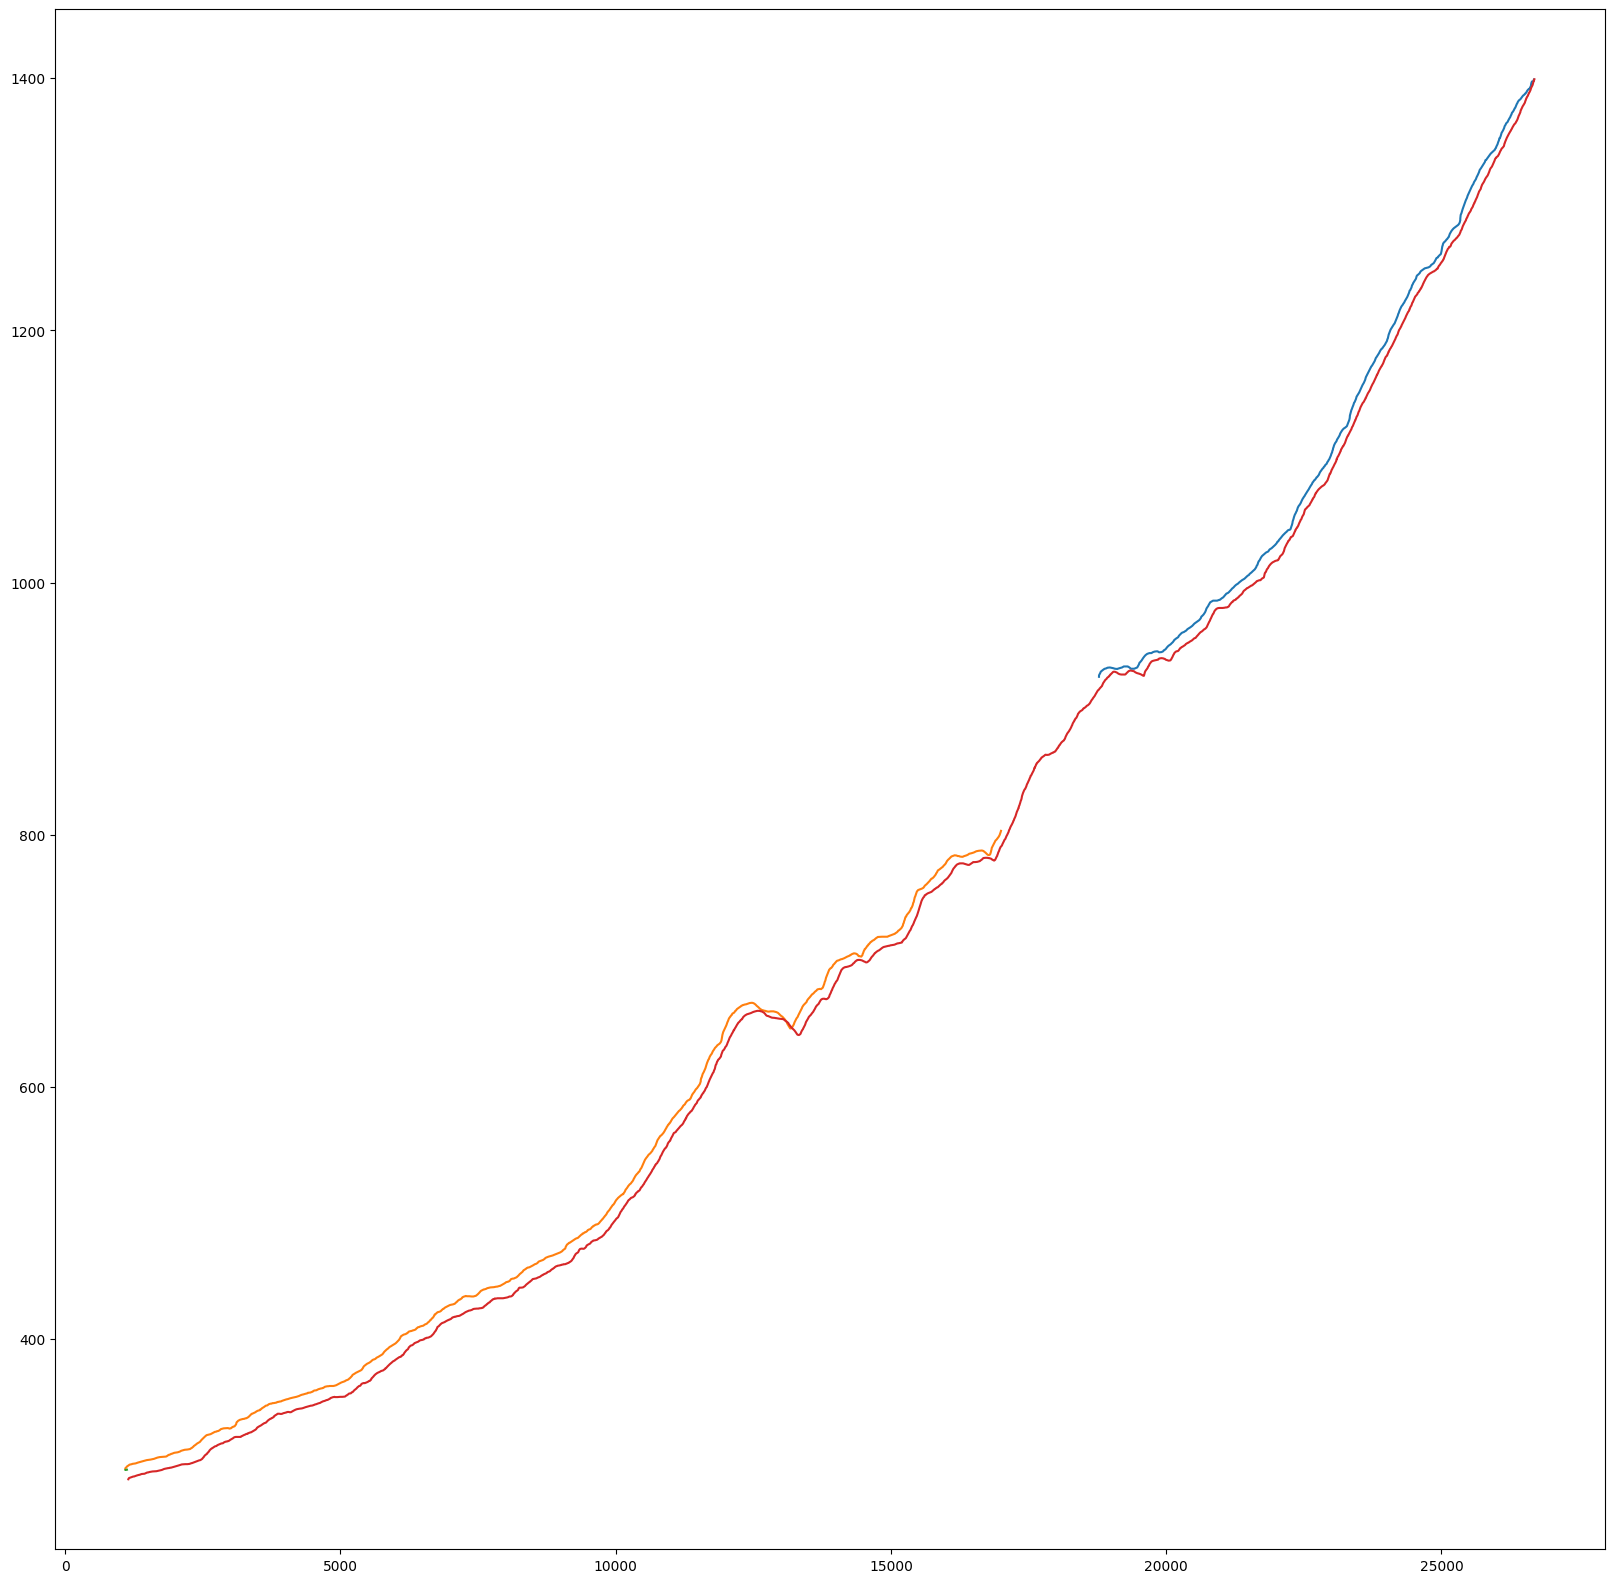

In [98]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
meta_segments,nodes_positions=get_meta_segments_along_path(path[:80],GG,G_proj)
t2=time.time()
print(t2-t1)
plt.rcParams['figure.figsize']=(20,20)
for file_path,L in meta_segments.items():
    for elem in L:
        X,Y=elem['X'],elem['Y']
        plt.plot(X,Y)
        #plt.scatter(X[0],Y[0],c='g')
        #plt.scatter(X[-1],Y[-1],c='r')


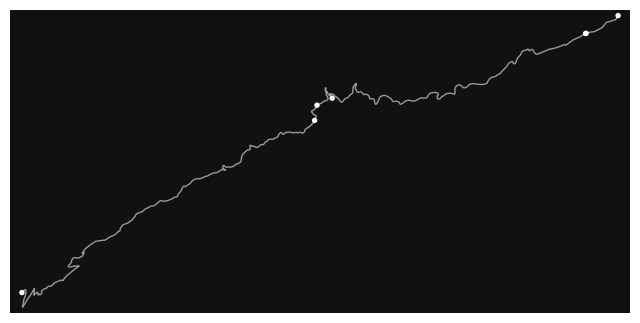

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [99]:
ox.plot_graph(nx.edge_subgraph(G_dir,map(tuple,path[:])))

0.013657093048095703 0.08854413032531738


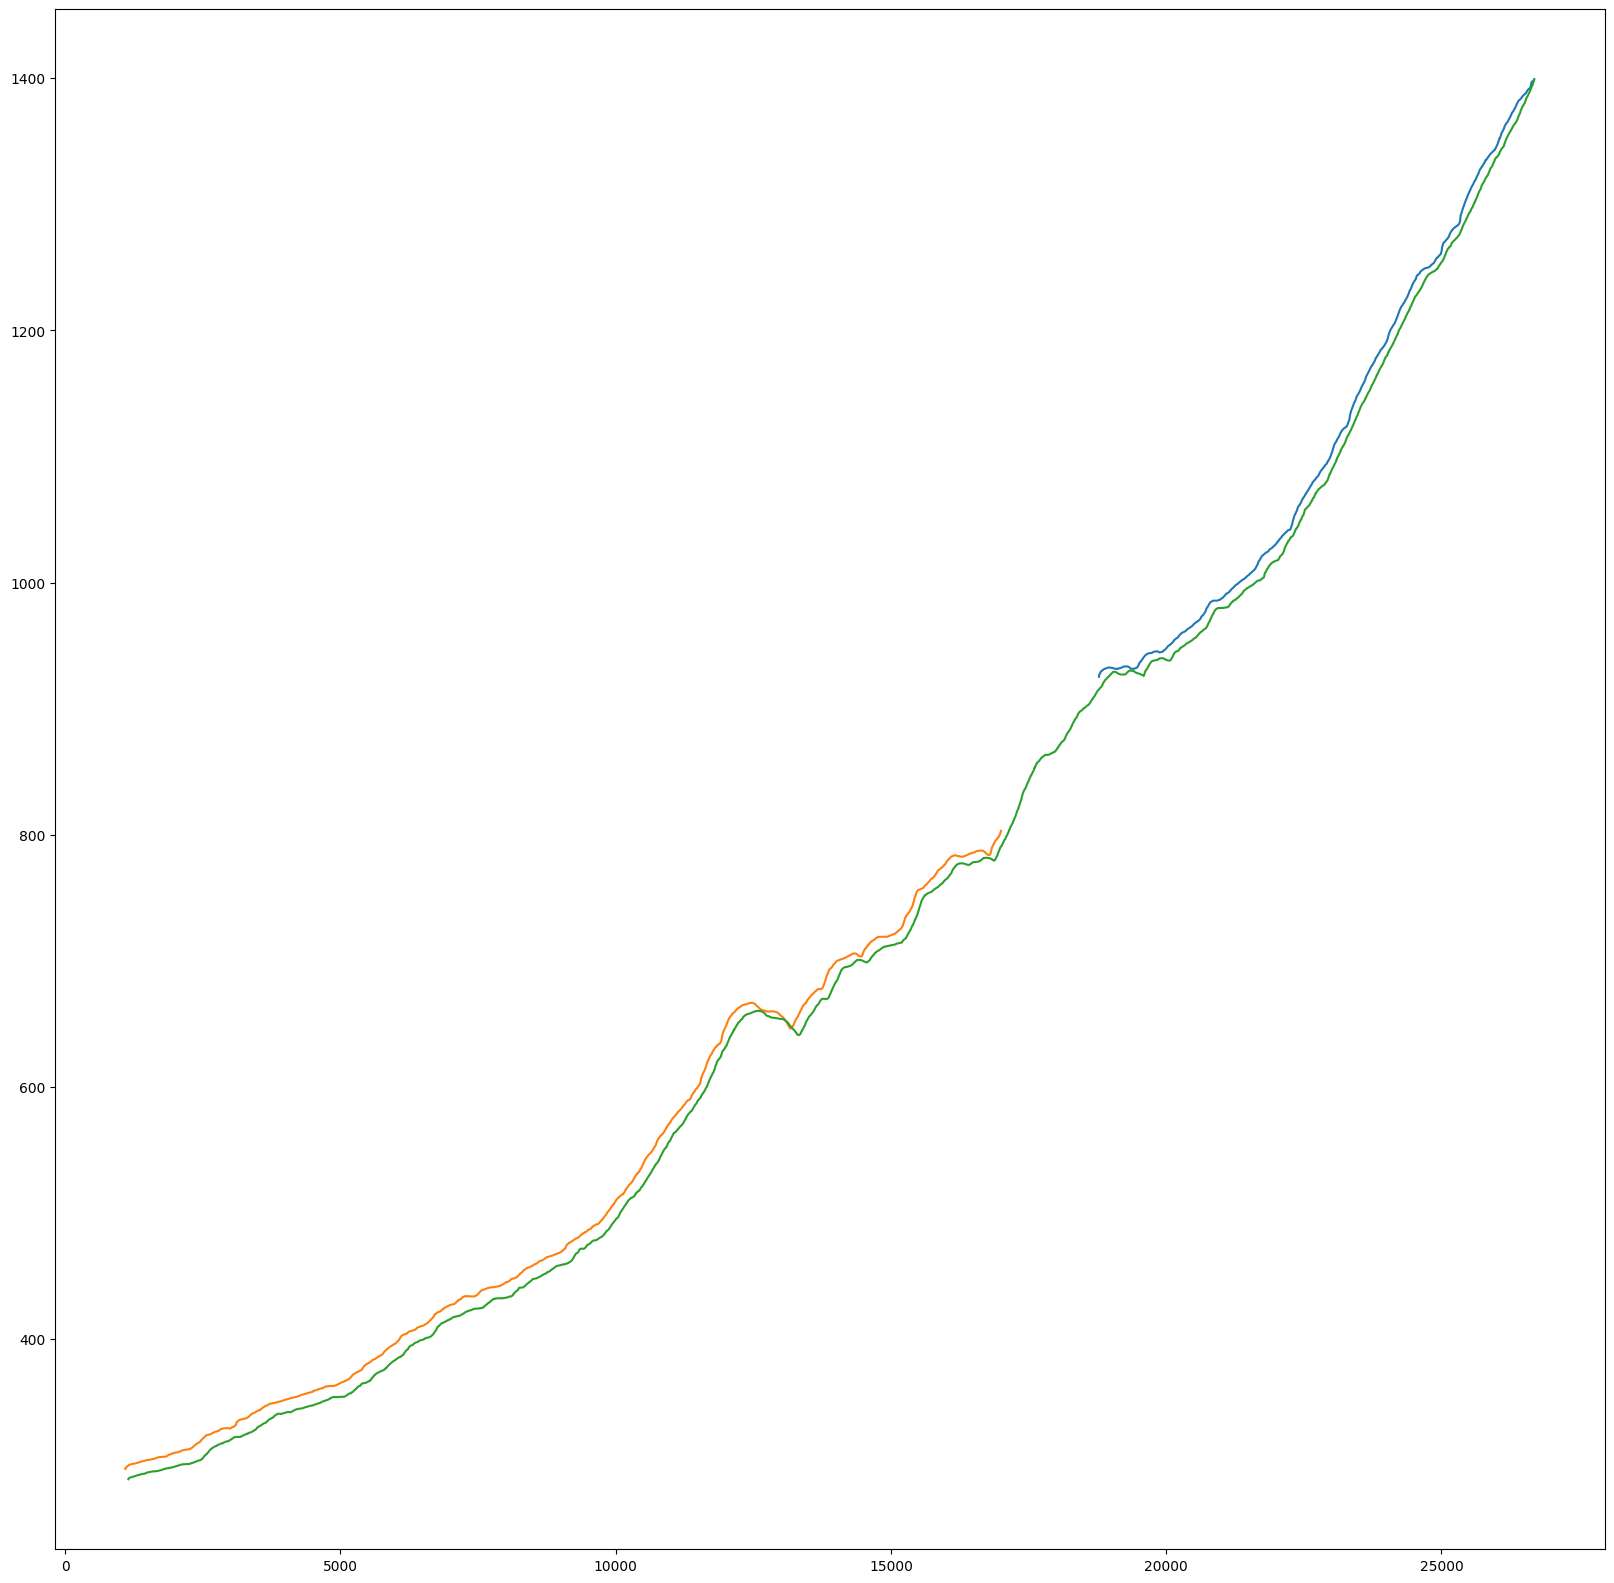

In [100]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
slopes=get_slopes(meta_segments,min_dist=500,max_dist=float('inf'))
slopes=harmonize_slopes(slopes)
t2=time.time()
pairwise_shifts,affine_slopes=get_pairwise_shifts(slopes,overlay_thresh=0.25,)
t3=time.time()
print(t3-t2,t2-t1)
for slope in slopes:
    plt.plot(slope['X'],slope['Y'])
for k in affine_slopes:
    slope=slopes[k]
    plt.plot(slope['X'],slope['Y'],c='k')    

9.608268737792969e-05


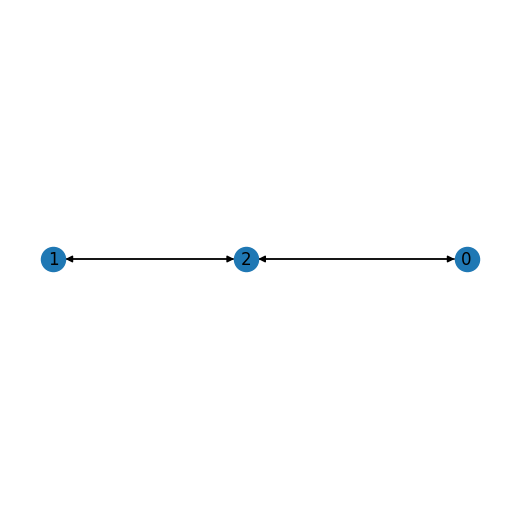

In [101]:
plt.rcParams['figure.figsize']=(5,5)

file_paths=list(np.unique(garmin_df['file_path']))
N=len(slopes)
pos={k:(np.mean(slopes[k]['X']),file_paths.index(slopes[k]['file_path'])) for k in range(N)} 
t1=time.time()
shift_G=get_shifts_graph(pairwise_shifts,len(slopes),corr_tresh=0.99)
t2=time.time()
print(t2-t1)

pos={k:(np.mean(slopes[k]['X']),file_paths.index(slopes[k]['file_path'])) for k in range(N)} 
nx.draw(shift_G,pos=pos,with_labels=True)

0.0004687309265136719


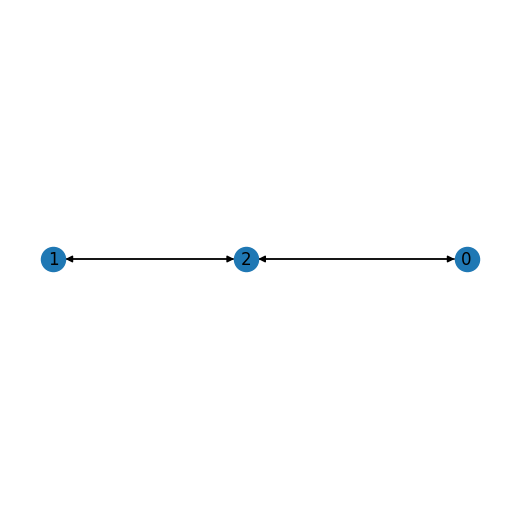

In [103]:
t1=time.time()
edges=list(nx.minimum_spanning_edges(nx.Graph(shift_G),weight='weight',data=False))
edges+=[(v,u) for u,v in edges]
shift_tree=nx.edge_subgraph(shift_G,edges)
t2=time.time()
print(t2-t1)
nx.draw(shift_tree,pos=pos,with_labels=True)

0.00048422813415527344


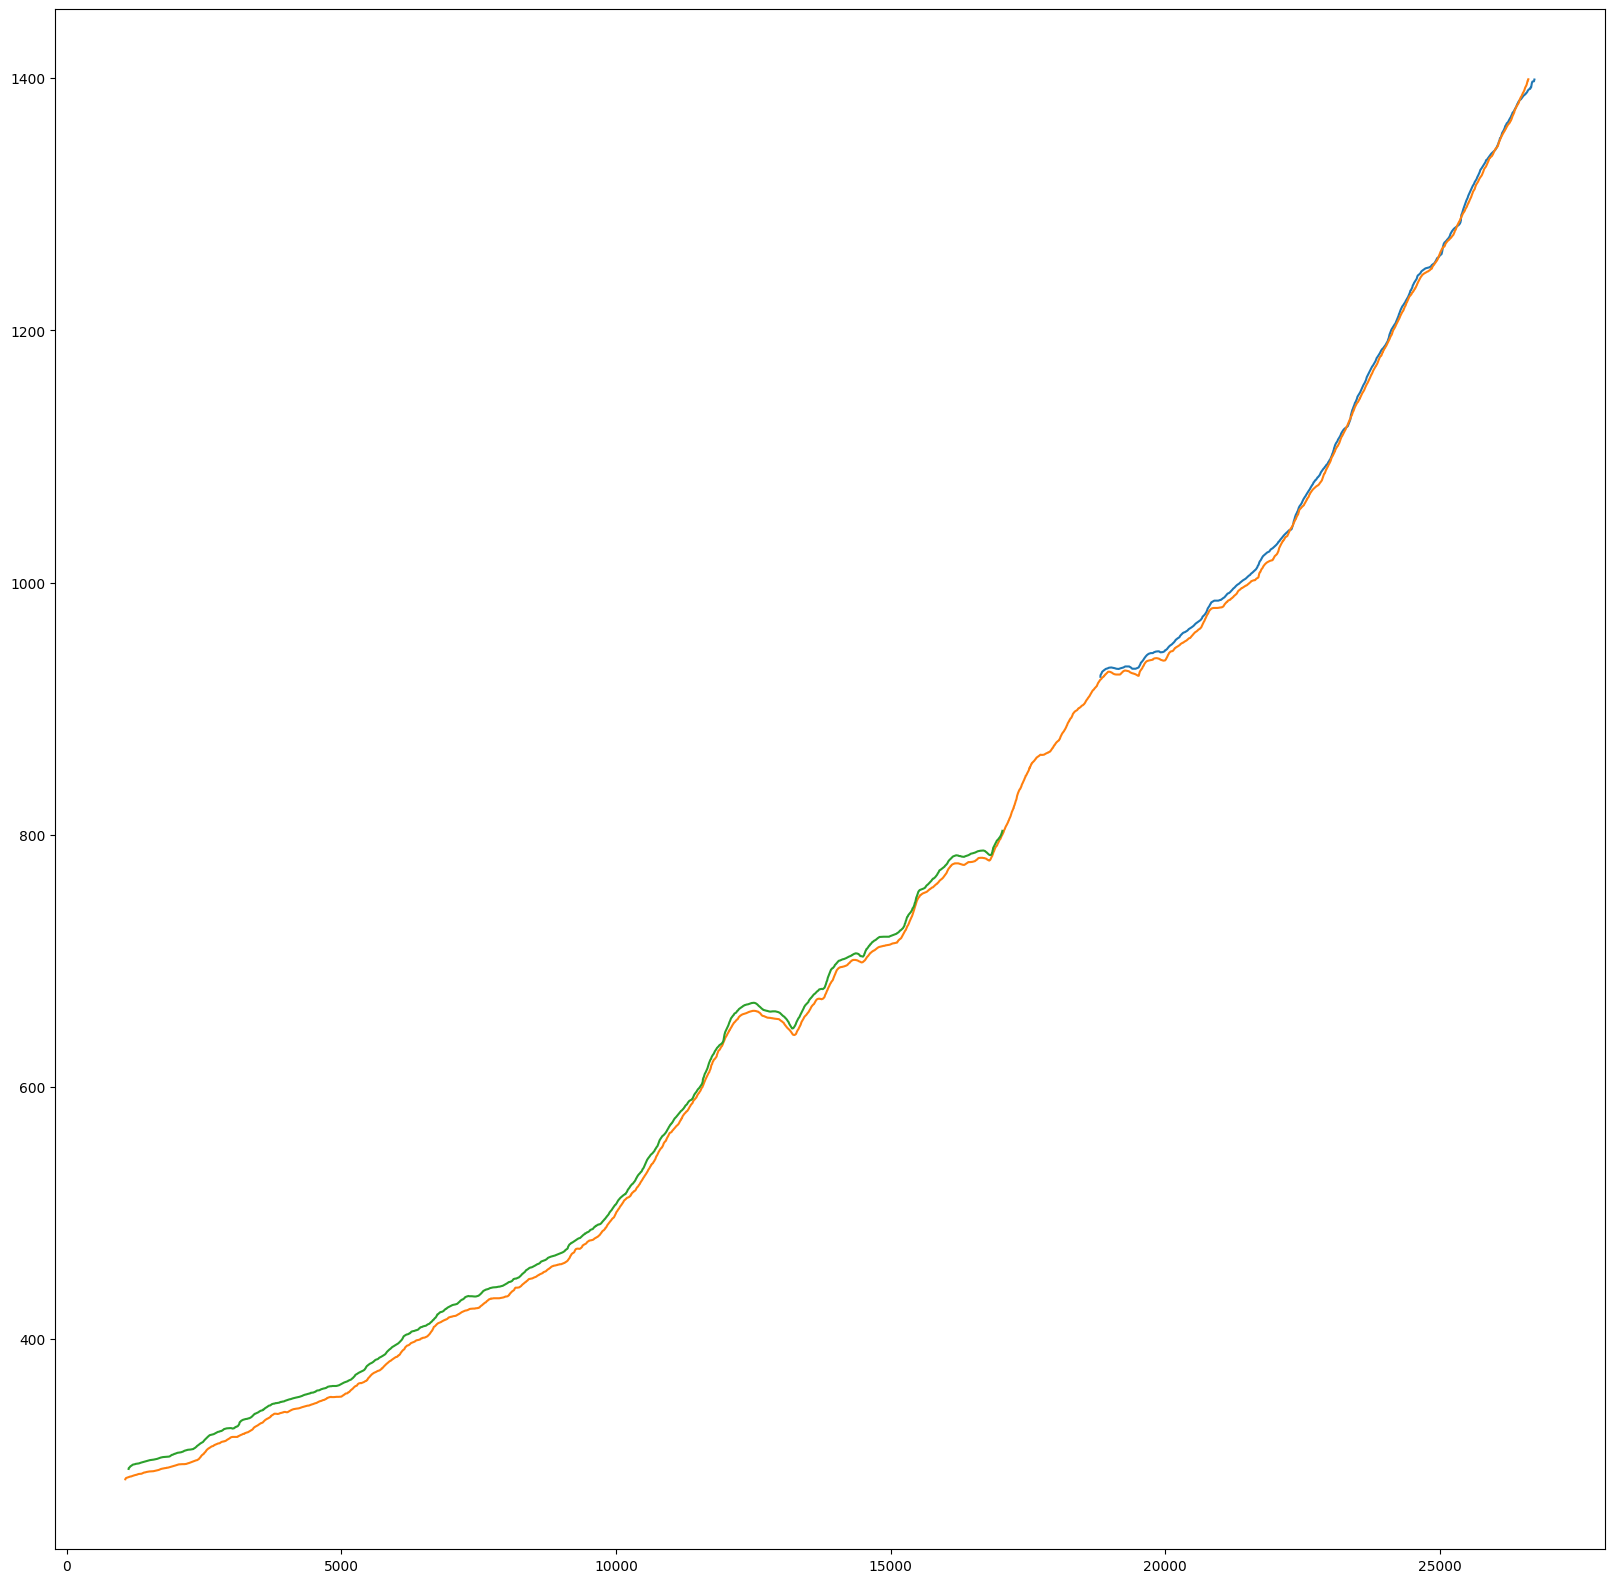

In [104]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
corrected_slopes,shifts=realign_slopes_from_tree(shift_tree,slopes,min_components=1)
corrected_slopes+=[slopes[k] for k in affine_slopes]
t2=time.time()
print(t2-t1)
for slope in corrected_slopes:
    plt.plot(slope['X'],slope['Y'])



In [105]:
cover,extremities=get_cover(corrected_slopes,min_count=2)

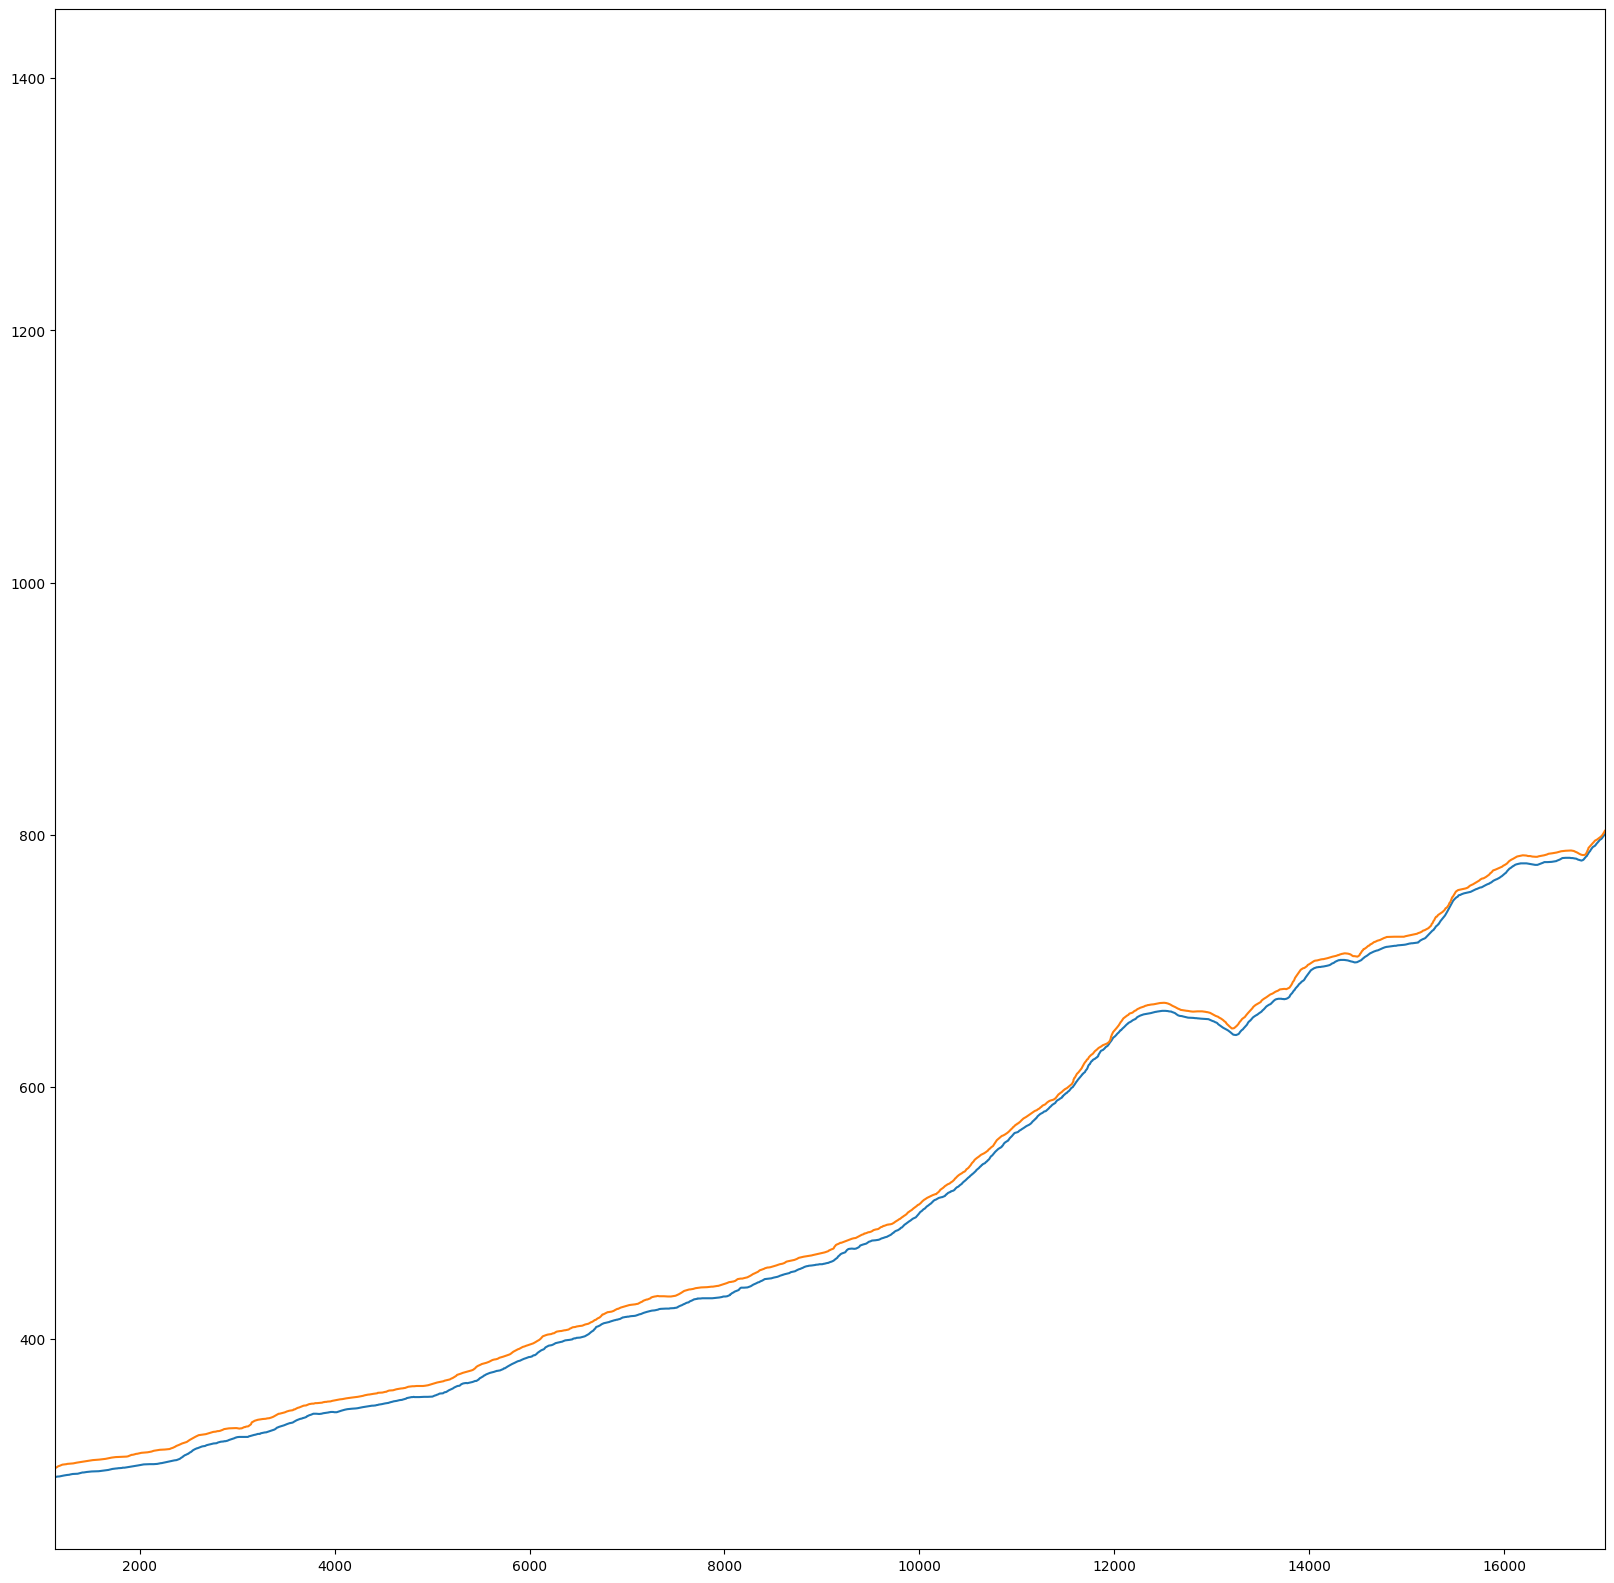

In [106]:
i=0
sub_slopes=[corrected_slopes[k] for k in cover[i]]
x_min,x_max=extremities[i]
plt.xlim(x_min,x_max)
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y'])    


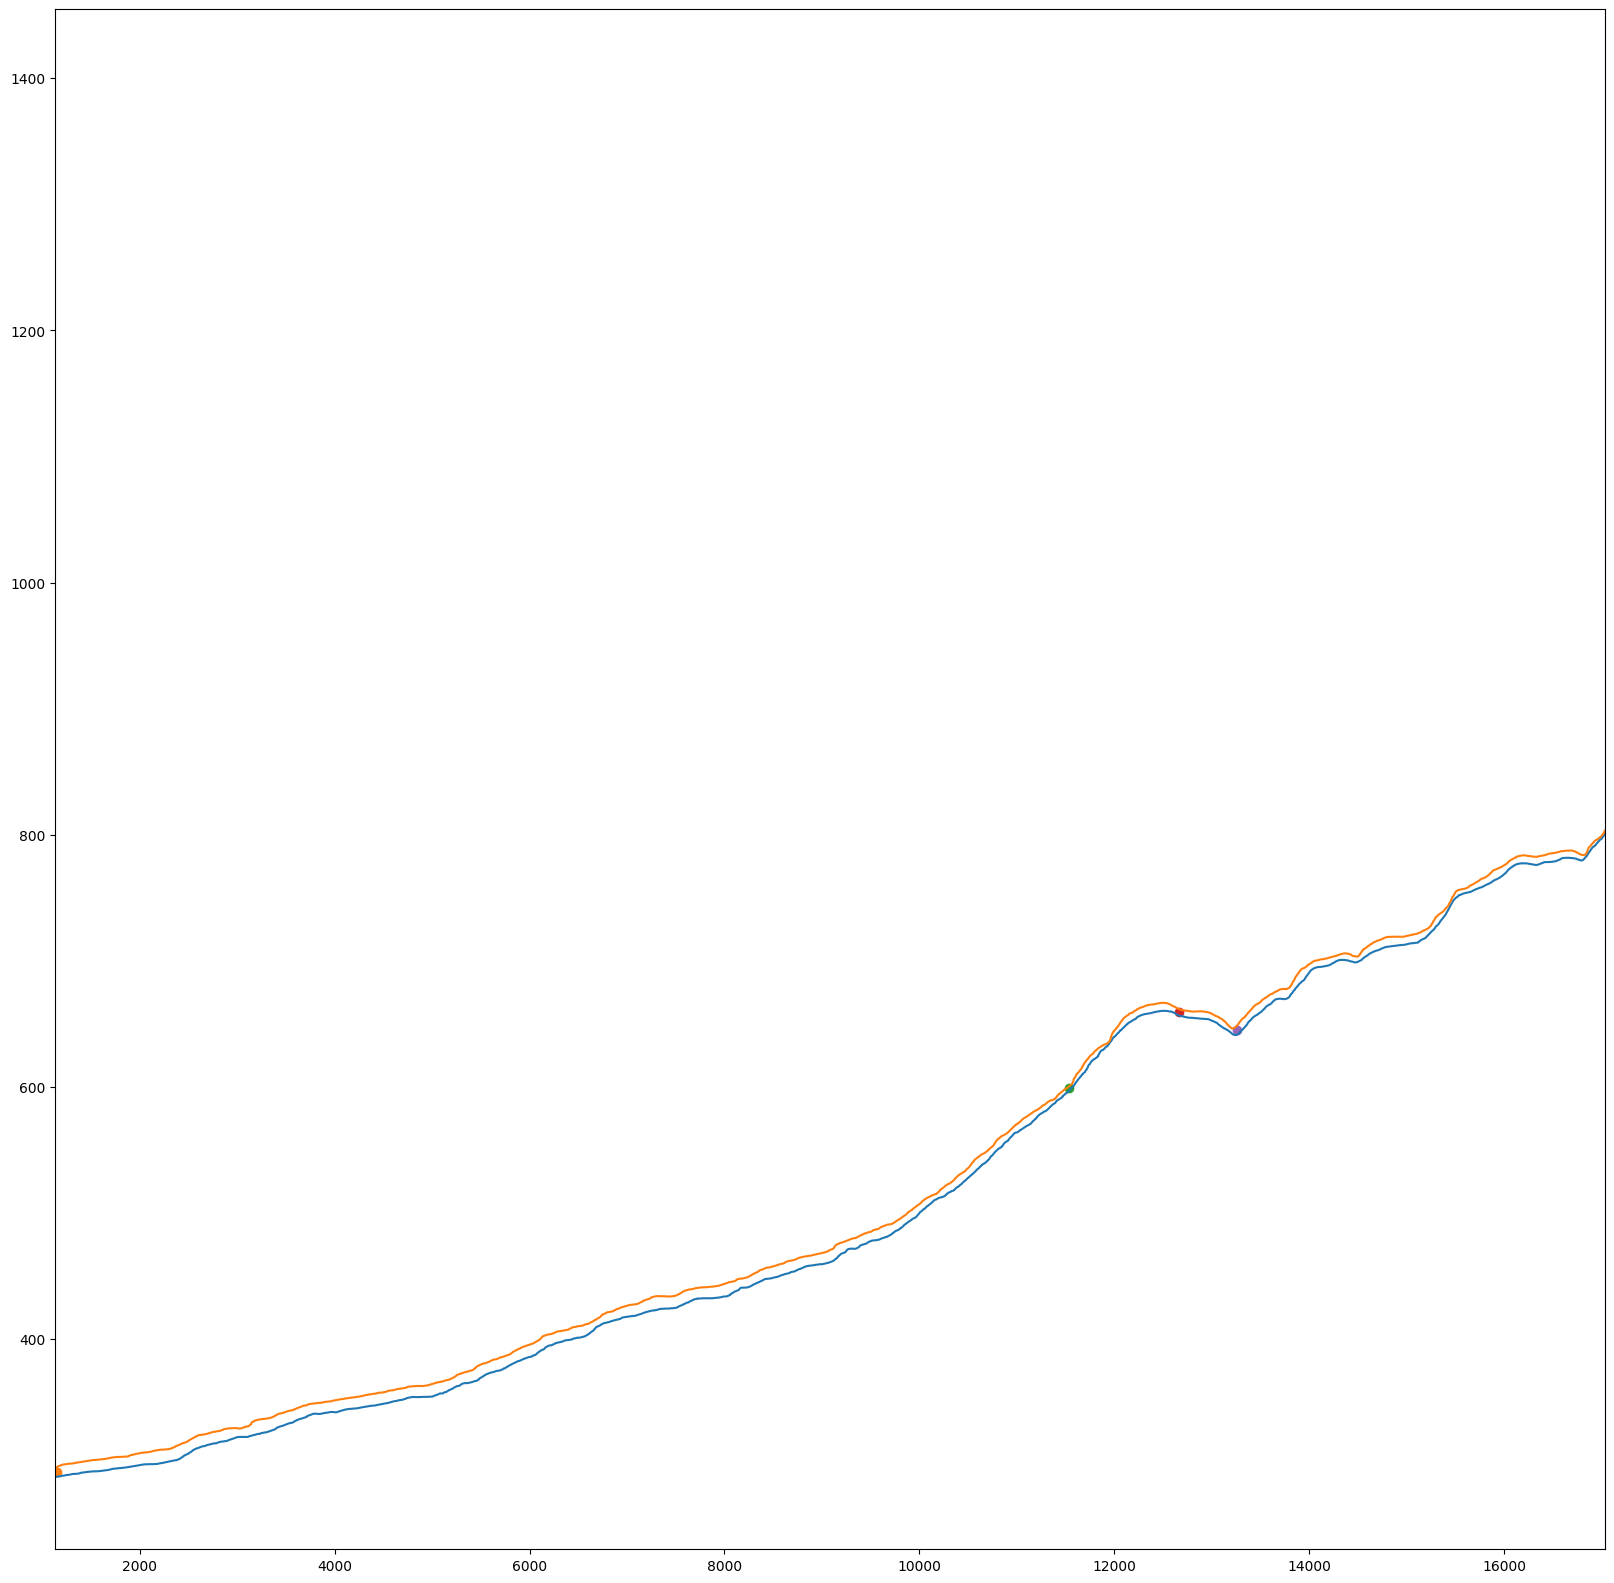

In [107]:
plt.xlim(x_min,x_max)
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y'])  
elevations,median_elevations=get_median_node_elevation(nodes_positions,sub_slopes,x_min,x_max,min_count=2)
for k,elev in median_elevations.items():
    plt.scatter(nodes_positions[k],elev)

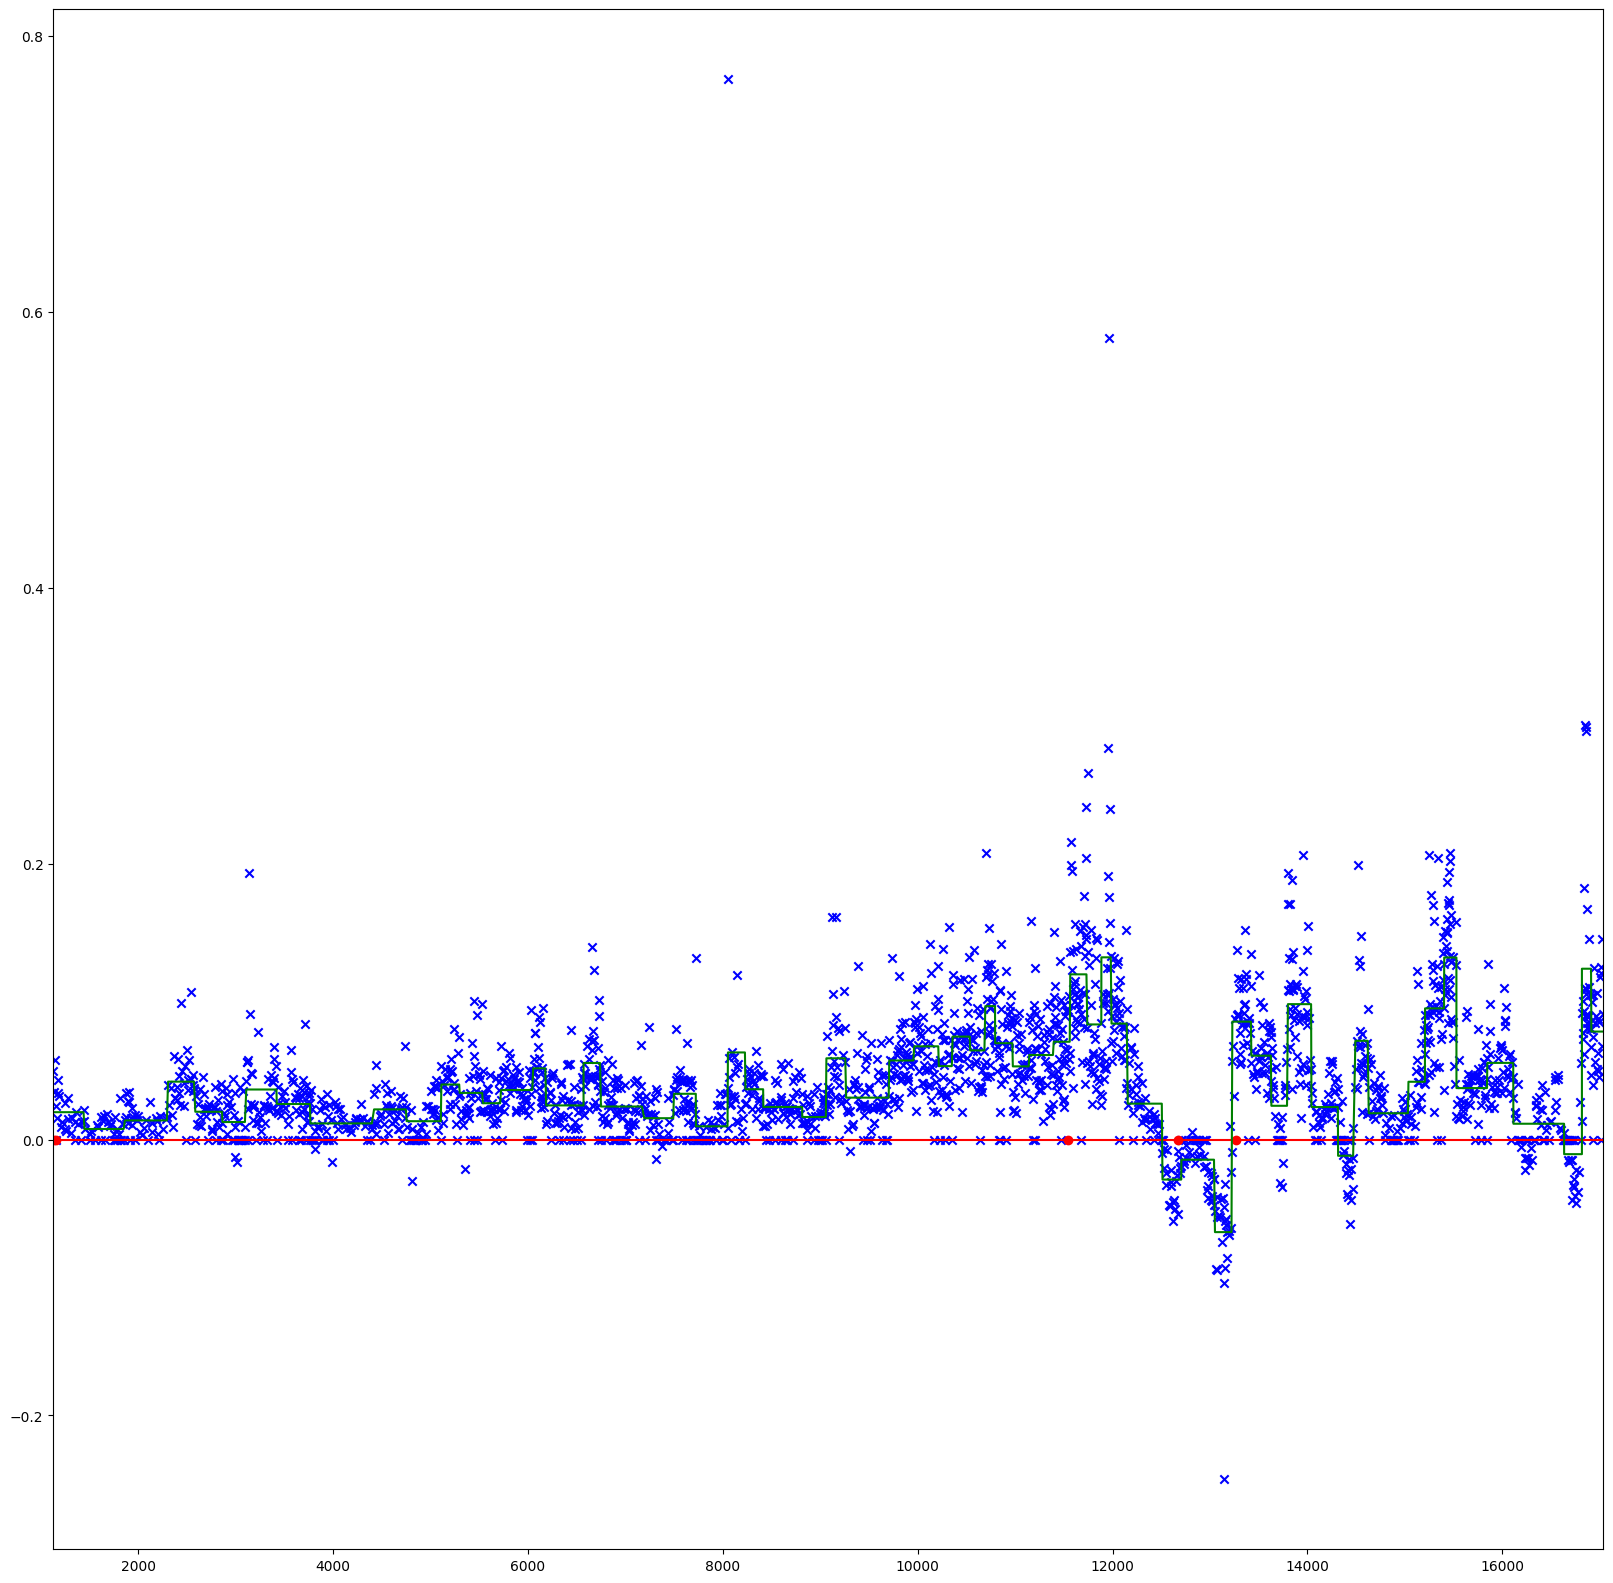

In [108]:
plt.xlim(x_min,x_max)
X,dYdX,model=approximate_derivative(sub_slopes,x_min=x_min,x_max=x_max,
                                    min_samples_leaf=25,min_impurity_decrease=0.2*float('1e-6'))
Z=model.predict(X.reshape(-1,1))
plt.scatter(X,dYdX,c='b',marker='x')
plt.plot([0,X[-1]],[0,0],c='r')
plt.plot(X,Z,c='g')
plt.scatter(nodes_positions,[0]*len(nodes_positions),c='r')


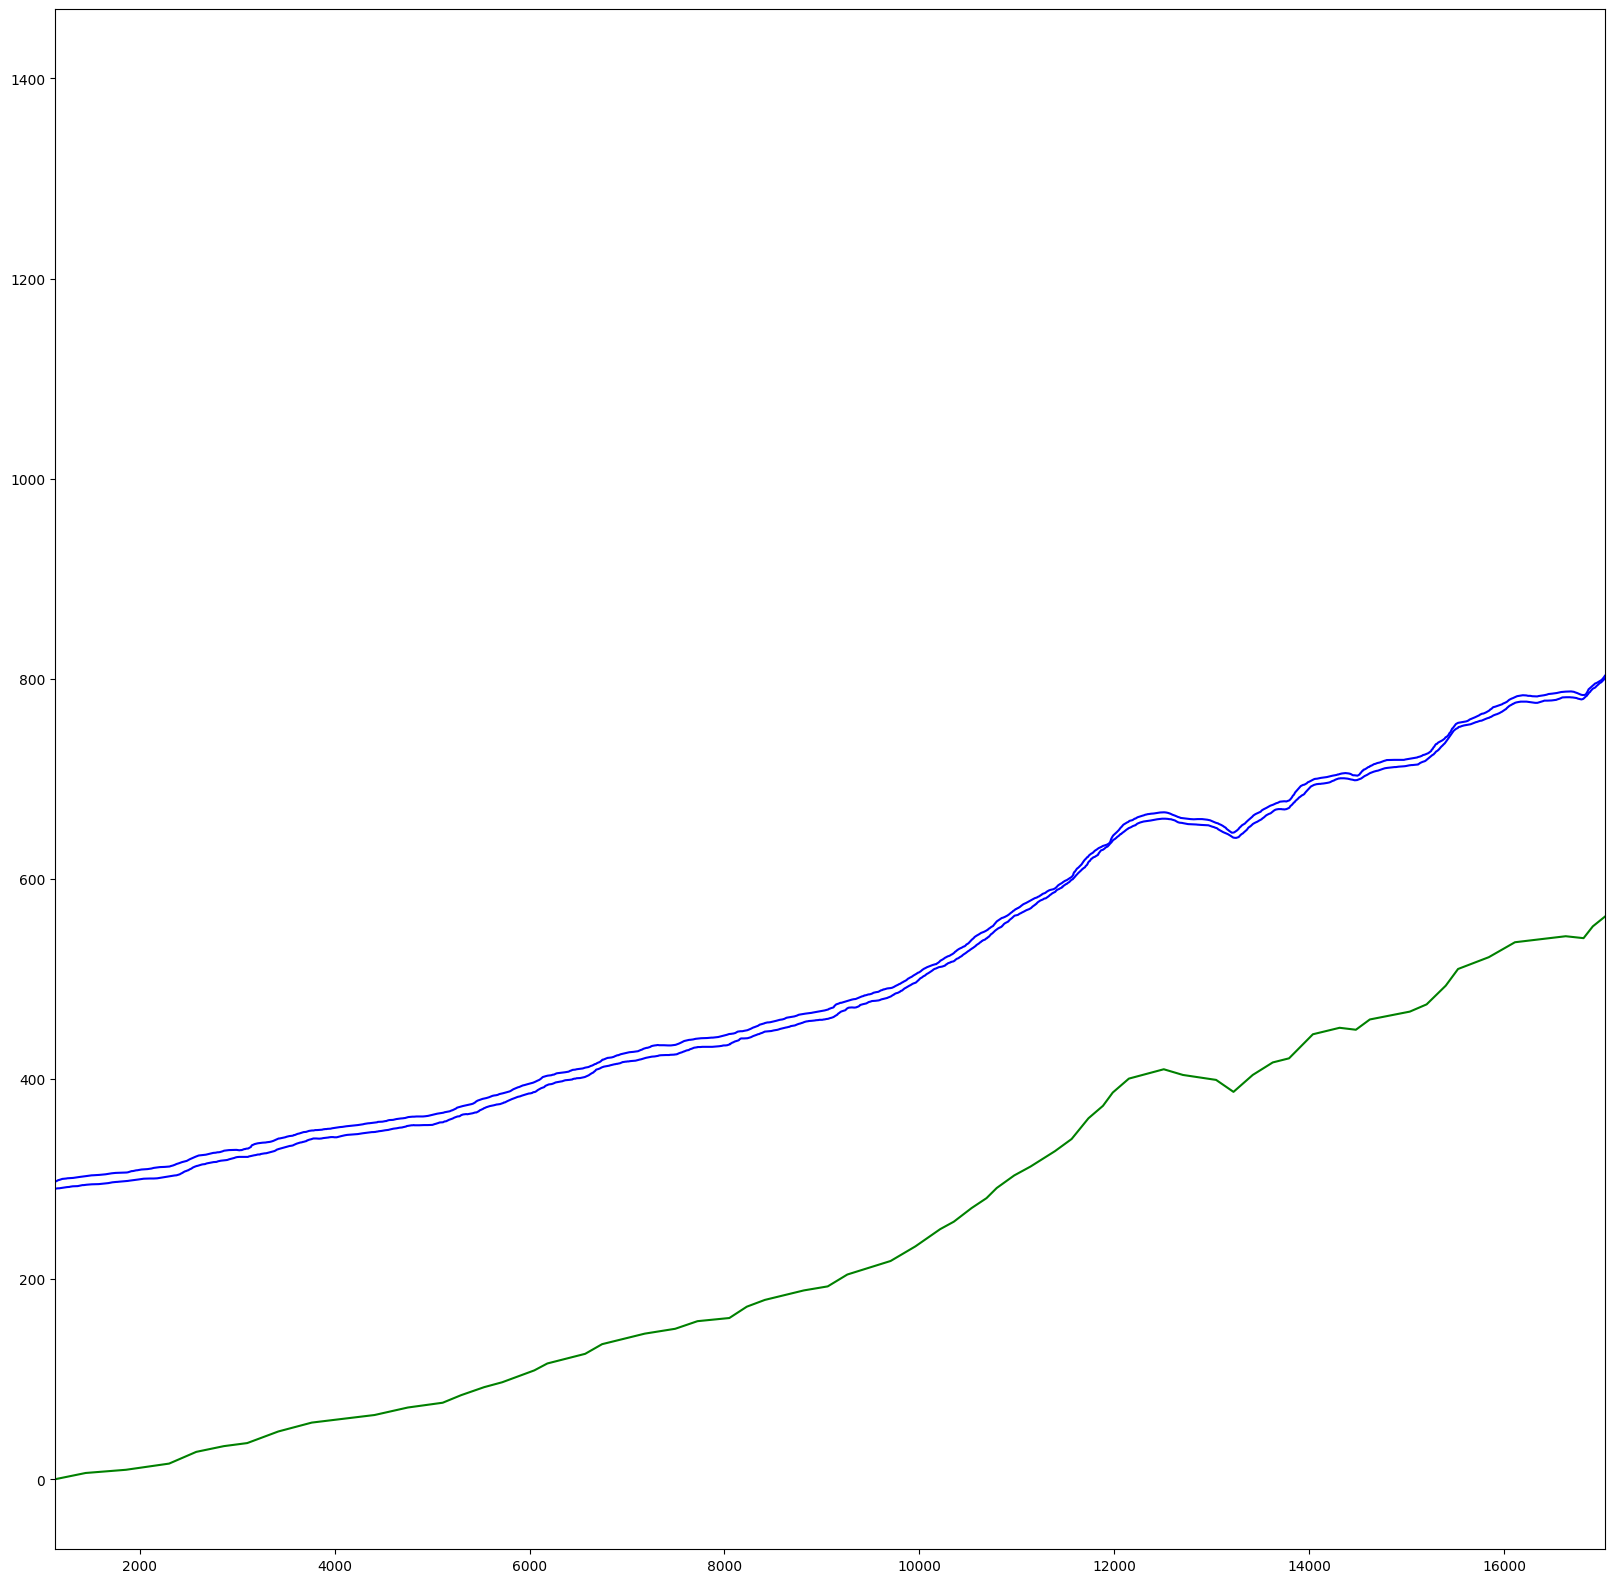

In [109]:
plt.xlim(x_min,x_max)
intervals=get_derivative_intervals(model.tree_)
intervals[0][0]=x_min
intervals[-1][1]=x_max

XX,YY=infer_curve_from_estimated_gradient(intervals)
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y'],c='b')  
plt.plot(XX,YY,c='g')


In [92]:
nodes_data,edges_data=collect_elevation_information_from_sub_slopes(path,nodes_positions,sub_slopes,x_min,x_max)
nodes_data,edges_data
_,ax=plt.subplots(len(edges_data))
for k,data in enumerate(edges_data.values()):
    for x1,x2,v in data:
        ax[k].plot([x1,x2],[v,v],c='g')
    ax[k].plot([0,x2],[0,0],c='r')


TypeError: unhashable type: 'list'

In [41]:
path=get_longest_path(GG,nx.minimum_spanning_tree(nx.Graph(GG)))
#ox.plot_graph(nx.edge_subgraph(G_dir,path))
ox.plot_graph(nx.edge_subgraph(G_dir,path[:37]))

TypeError: OutEdgeView.__call__() got an unexpected keyword argument 'keys'

In [121]:
GG.remove_edges_from(path)

In [126]:
len(path)

111